In [1]:
import torch
import numpy as np
from ema_pytorch import EMA
from gradeif import EGNN_NET,GraDe_IF
import torch.nn.functional as F

amino_acids_type = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
                
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt = torch.load('results/weight/UNIFORM_3M_small.pt', map_location=device)#BLOSUM_3M_small.pt
config = ckpt['config']
config['noise_type'] = 'uniform'#blosum


gnn = EGNN_NET(input_feat_dim=config['input_feat_dim'],hidden_channels=config['hidden_dim'],edge_attr_dim=config['edge_attr_dim'],dropout=config['drop_out'],n_layers=config['depth'],update_edge = config['update_edge'],embedding=config['embedding'],embedding_dim=config['embedding_dim'],embed_ss=config['embed_ss'],norm_feat=config['norm_feat'])

diffusion = GraDe_IF(model = gnn,config=config)

diffusion = EMA(diffusion)
diffusion.load_state_dict(ckpt['ema'])




<All keys matched successfully>

### generate graph from pdb file

In [2]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)
import torch_geometric
from torch_geometric.data import Batch
from dataset_src.generate_graph import prepare_graph,pdb2graph

pdb_path = '../dataset/raw/test/3fkf.A.pdb'
graph = pdb2graph(pdb_path,normalize_path = '../dataset_src/mean_attr.pt')
input_graph = Batch.from_data_list([prepare_graph(graph)])
print(input_graph)




DataBatch(x=[140, 20], edge_index=[2, 1400], edge_attr=[1400, 93], pos=[140, 3], extra_x=[140, 11], ss=[140, 8], sasa=[140], batch=[140], ptr=[2])


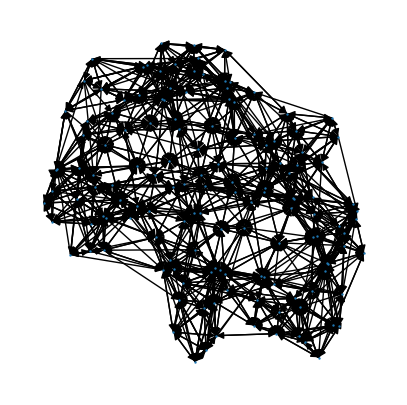

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,figsize=(5, 5))
g = torch_geometric.utils.to_networkx(input_graph)
nx.draw(g,node_size=0.5,pos=input_graph.pos[:,1:3].cpu().numpy(),ax=ax)

In [8]:
prob,sample_graph = diffusion.ema_model.ddim_sample(input_graph)
recovery = (prob.argmax(dim=1) == input_graph.x.argmax(dim = 1)).sum()/(input_graph.x.argmax(dim=1) == input_graph.x.argmax(dim = 1)).shape[0]
print('sample sequence: ', ''.join([amino_acids_type[i] for i in sample_graph.argmax(dim=1).tolist()]))
print(recovery.item())

prob,sample_graph = diffusion.ema_model.ddim_sample(input_graph,diverse=True)
recovery = (prob.argmax(dim=1) == input_graph.x.argmax(dim = 1)).sum()/(input_graph.x.argmax(dim=1) == input_graph.x.argmax(dim = 1)).shape[0]
print('sample sequence: ', ''.join([amino_acids_type[i] for i in sample_graph.argmax(dim=1).tolist()]))
print('sample sequence with diveristy mode: ',recovery.item())

  0%|          | 0/10 [00:00<?, ?it/s]

sample sequence:  ITVGETIPYFSLPDLKGEKLSPSSDEFKNKYVLLVFYSAHSLPQPDFIAGLKRLEKEYKKNENFVLIVSTDQDRHALLTAIEEADLSGPVVSDFTGLSSKVLKDLAIKTLPTRILLSPTGKILGIDIKGKALVSFLKDAL
0.5857142806053162


  0%|          | 0/10 [00:00<?, ?it/s]

sample sequence:  VPVGEDIPYFSLPDEEGEQLSFSSMRYKNKYVVIVFYSSHSLPQPDWFSGLKRLYKEYEKDDDFIIIFSLDQDWHAMLTAIEEASLACPITGDFEGLSSKVNKNLAVKTLPTRLVLSPDGRILGVHIRGHSLLTWHKESC
sample sequence with diveristy mode:  0.4571428596973419


### Control diversity of sample sequence by step size

In [ ]:
step_list = [50,10,5,1]
record = {}
diversity_record = {}
for step in step_list:
    recovery_list = []  
    sample_list = []
    for i in range(10):
        prob,sample_graph = diffusion.ema_model.ddim_sample(input_graph,step=step)
        recovery = (sample_graph.argmax(dim=1) == input_graph.x.argmax(dim = 1)).sum()/input_graph.x.shape[0]
        recovery_list.append(recovery.item())
        sample_list.append(sample_graph)
    record[step] = np.mean(recovery_list)
    diversity = 1 - (sample_list[0].argmax(dim=1) == sample_list[1].argmax(dim = 1)).sum()/input_graph.x.shape[0]
    diversity_record[step] = diversity.item()

for step in step_list:
    print(step)
    print('recovery:',record[step])
    print('diversity:',diversity_record[step])

### By aggregating the probabilities of each sample, we can mitigate uncertainty originating from the prior $ x_T $, resulting in $ p(x_{aa}) $, which exhibits an enhanced recovery rate.

In [9]:
ensemble_num = 50
all_prob = []
for i in range(ensemble_num):
    prob,sample_graph = diffusion.ema_model.ddim_sample(input_graph,step=50,diverse=True)
    all_prob.append(prob)

all_zt_tensor = torch.stack(all_prob)
recovery = (all_zt_tensor.mean(dim = 0).argmax(dim=1) == input_graph.x.argmax(dim = 1)).sum()/input_graph.x.shape[0]
print('recovery rate:', recovery.item())
ll_fullseq = F.cross_entropy(all_zt_tensor.mean(dim = 0),input_graph.x.argmax(dim = 1), reduction='mean').item()
perplexity = np.exp(ll_fullseq)
print('perplexity:' , perplexity)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

recovery rate: 0.5928571224212646
perplexity: 5.174304278646553


### Leveraging Biological Substitution Matrices to Guide the Generative Process

Biological substitution matrices, such as the BLOSUM, can serve as transition matrices to inform and steer the generative process. The BLOSUM matrix is a popular choice due to its general applicability; however, one can also construct a 'task-specific' transition matrix through Multiple Sequence Alignment (MSA) to tailor the matrix more closely to the requirements of the task at hand. Additionally, position-wise transition probability matrices can be employed to accommodate variations that are dependent on the specific location within the sequence. 

<AxesSubplot: >

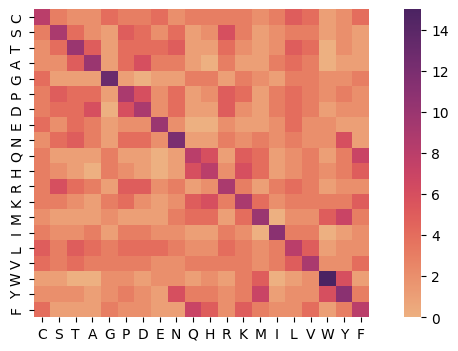

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import colors

original_score = torch.load('../dataset_src/blosum_substitute.pt')['original_score']
order = ['C', 'S', 'T', 'A', 'G', 'P', 'D', 'E', 'N', 'Q', 'H', 'R', 'K', 'M', 'I', 'L', 'V', 'W', 'Y', 'F']
original_score = pd.DataFrame(original_score.numpy(), columns = order, index=order)
# Create a figure and a gridspec
fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05])

# Create two subplots for the heatmaps

ax1 = plt.subplot(gs[0])
# Create a second subplot for the colorbar
cbar_ax = plt.subplot(gs[1])
# Draw heatmaps
sns.heatmap(original_score,vmin=5, ax=ax1, norm=colors.PowerNorm(gamma=1), cmap='flare', cbar_ax=cbar_ax)


In [10]:
config['noise_type'] = 'blosum'


gnn = EGNN_NET(input_feat_dim=config['input_feat_dim'],hidden_channels=config['hidden_dim'],edge_attr_dim=config['edge_attr_dim'],dropout=config['drop_out'],n_layers=config['depth'],update_edge = config['update_edge'],embedding=config['embedding'],embedding_dim=config['embedding_dim'],embed_ss=config['embed_ss'],norm_feat=config['norm_feat'])

diffusion = GraDe_IF(model = gnn,config=config)

diffusion = EMA(diffusion)
diffusion.load_state_dict(ckpt['ema'])

<All keys matched successfully>

In [11]:
print('generate with :',diffusion.ema_model.config['noise_type'])

prob,sample_graph = diffusion.ema_model.ddim_sample(input_graph)
recovery = (prob.argmax(dim=1) == input_graph.x.argmax(dim = 1)).sum()/(input_graph.x.argmax(dim=1) == input_graph.x.argmax(dim = 1)).shape[0]
print('sample sequence: ', ''.join([amino_acids_type[i] for i in sample_graph.argmax(dim=1).tolist()]))
print(recovery.item())

prob,sample_graph = diffusion.ema_model.ddim_sample(input_graph,diverse=True)
recovery = (prob.argmax(dim=1) == input_graph.x.argmax(dim = 1)).sum()/(input_graph.x.argmax(dim=1) == input_graph.x.argmax(dim = 1)).shape[0]
print('sample sequence: ', ''.join([amino_acids_type[i] for i in sample_graph.argmax(dim=1).tolist()]))
print('sample sequence with diveristy mode: ',recovery.item())

generate with : blosum


  0%|          | 0/10 [00:00<?, ?it/s]

sample sequence:  VTVGETIPYFSLPDLKGQKWSRDDDEFKNKYVVFLFYSAHCLPQPDYIACKRWLEKKYKKNENFVLWVSTDIDWEAWCTAIEKCDLSCPWVCDFTGLSSEWLKDLAIETLPTWIVLSPDGRILAIDIWGWSLLSHLRDAL
0.550000011920929


  0%|          | 0/10 [00:00<?, ?it/s]

sample sequence:  VPIGECVPWFCWPDWMGEWLCWNAVMLKDKYLFFCFYSAHSLPNPEWMGCLRWWHHQYHKDKKVAWLVDTDMDREAECTGIWKWDISCWWCCNFTGFSSRILKDWGIKWLPTWVILSPDGKIMAVDIWGEALCAYIRDCL
sample sequence with diveristy mode:  0.3857142925262451


### Generate partial amino acid and fix some amino acid

In [13]:
prob,sample_graph = diffusion.ema_model.ddim_sample(input_graph)
recovery = (prob.argmax(dim=1) == input_graph.x.argmax(dim = 1)).sum()/(input_graph.x.argmax(dim=1) == input_graph.x.argmax(dim = 1)).shape[0]
print('sample whole sequence: ', ''.join([amino_acids_type[i] for i in sample_graph.argmax(dim=1).tolist()]))

prob,sample_graph = diffusion.ema_model.ddim_sample(input_graph,cond=torch.tensor([0,1,2,3,4,5]))
recovery = (prob.argmax(dim=1) == input_graph.x.argmax(dim = 1)).sum()/(input_graph.x.argmax(dim=1) == input_graph.x.argmax(dim = 1)).shape[0]
print('fix first 6 aa, sample sequence: ', ''.join([amino_acids_type[i] for i in sample_graph.argmax(dim=1).tolist()]))

print('original sequence: ', ''.join([amino_acids_type[i] for i in input_graph.x.argmax(dim=1).tolist()]))

  0%|          | 0/10 [00:00<?, ?it/s]

sample whole sequence:  WTVGETVPYFSLPDLKGEWLSRDSPEFKNKYVIFCFYSAHCLPHPDWYACWRWLEKLYKKNENFVLIVSTDIDRQAWCDAIEKCDISFPWVWNYTGDSSKLCKDWAVQTLPTWVILSPDGRILAINIKGWALWDWLRDWL


  0%|          | 0/10 [00:00<?, ?it/s]

fix first 6 aa, sample sequence:  VTVGKSLPYFSLPDLKGEKLSWDDDEFRNKYVILCFYSAHCLPQPDWWADLKWLWKKYEKNENYVLWVSTDIDWEALNTAIEKCDISGPWVSDFTGWSSEWLKDLAIQTLPTWIILSPDGRILAIDIKGKALWDYLKDWL
original sequence:  VTVGKSAPYFSLPNEKGEKLSRSAERFRNRYLLLNFWASWCDPQPEANAELKRLNKEYKKNKNFALGISLDIDREAWETAIKKDTLSWDQVCDFTGLSSETAKQYAILTLPTNILLSPTGKILARDIQGEALTGKLKELL
